In [1]:
import math, random, os, sys
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32

In [ ]:
# load MNIST
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),  # flatten 28x28 → 784
    transforms.Lambda(lambda v: (v - v.mean()) / (v.std() + 1e-8))
])

mnist = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)

def sample_digit(digit, device="cpu"):
    
    idxs = [i for i, (_, y) in enumerate(mnist) if y == digit]
    i = random.choice(idxs)     
    v, y = mnist[i]
    return v.view(-1).to(device)

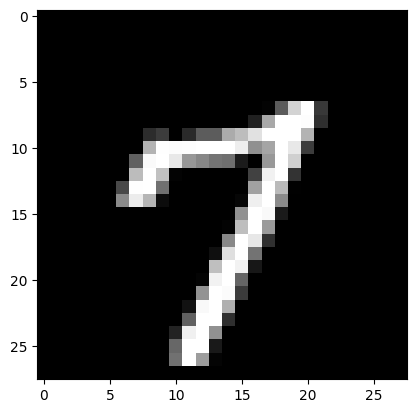

In [5]:
plt.imshow(sample_digit(7).view(28,28), cmap="gray")
plt.show()

In [ ]:
# Constants
kBT = 1.0
mu = 1.0
J2 = 10.0
J4 = 10.0

# Chosen through trial and error
bias_scale = 20.0

Nv = 28*28  # number of visible units
Nh = 512     # number of hidden units

J_vh = torch.zeros(Nv, Nh, device=device)   # visible-to-hidden couplings
J_hh = torch.zeros(Nh, Nh, device=device)   # hidden-to-hidden couplings
b_h  = torch.zeros(Nh, device=device)       # hidden biases
# no visible-to-visible couplings

def energy_and_grad(x_v, x_h, b_v, b_h, J_vh, J_hh):
  
    b_v = b_v.to(x_v.device)
    b_h = b_h.to(x_h.device)
    
    # Compute V_theta(x) and its gradients (autograd)
    x_v = x_v.clone().detach().requires_grad_(True)
    x_h = x_h.clone().detach().requires_grad_(True)
    
    # Energy terms
    V = J2*(x_v.pow(2).sum() + x_h.pow(2).sum()) \
      + J4*(x_v.pow(4).sum() + x_h.pow(4).sum()) 
    V = V + (b_v @ x_v) + (b_h @ x_h) 
    V = V + (x_v @ J_vh @ x_h) + 0.5*(x_h @ J_hh @ x_h)
    
    V.backward()

    g_v = x_v.grad.detach()
    g_h = x_h.grad.detach()

    return V.item(), g_v, g_h

In [6]:
def euler_maruyama_step(x_v, x_h, b_v, b_h, J_vh, J_hh, dt, kBT=1.0, mu=1.0):
    
    # Compute energy and gradients
    V, g_v, g_h = energy_and_grad(x_v, x_h, b_v, b_h, J_vh, J_hh)
    
    # Gaussian noise
    noise_v = torch.randn_like(x_v)
    noise_h = torch.randn_like(x_h)
    
    sigma = torch.sqrt(torch.tensor(2.0 * mu * kBT * dt, device=x_v.device, dtype=x_v.dtype))

    # Euler-Maruyama update
    x_vn = x_v - mu * g_v * dt + sigma * noise_v
    x_hn = x_h - mu * g_h * dt + sigma * noise_h
    
    return  x_vn, x_hn, V

In [8]:
# Projection (Random Projection) 
# TODO: try alternatives
U = torch.randn(Nh, Nv, device=device) / math.sqrt(Nv)

def fade_schedule(k: int, K: int) -> float:
    """Linear fade from 1 → 0 over K steps."""
    return 1.0 - (k / K)

def visible_bias_schedule(P: torch.Tensor, k: int, K: int, scale=1.0) -> torch.Tensor:
    return (scale * fade_schedule(k, K) * P).to(P.device)

# Project visible bias onto hidden units
def hidden_bias_schedule(P: torch.Tensor, k: int, K: int, scale=1.0) -> torch.Tensor:
    return (scale * fade_schedule(k, K) * (U @ P)).to(P.device)

In [ ]:
# Forward noising trajectory

def run_noising_trajectory(P, tf=2.5, dt=1e-3, snapshots=12, t_eq=0.5, use_trainable=False):
    
    K = int(tf / dt)
    snap_every = max(1, K // snapshots)
    
    if use_trainable:
        Jvh, Jhh = J_vh, J_hh   # trainable parameters
    else:
        Jvh = torch.zeros_like(J_vh)
        Jhh = torch.zeros_like(J_hh)
    
    x_v = torch.randn(Nv, device=device)
    x_h = torch.randn(Nh, device=device)

    states_all = []
    vis_snaps = []
    
    # Reach equilibrium
    K_eq = int(t_eq / dt)
    for _ in range(K_eq):
        b_v = (P * bias_scale).to(P.device)
        b_h = ((U @ P) * bias_scale).to(P.device)    
        x_v, x_h, V = euler_maruyama_step(x_v, x_h, b_v, b_h, Jvh, Jhh, dt, kBT, mu)

    states_all.append((x_v.clone(), x_h.clone()))
    for k in range(K):
        b_v = visible_bias_schedule(P, k, K, scale=bias_scale)
        b_h = hidden_bias_schedule(P, k, K, scale=bias_scale)

        x_v, x_h, V = euler_maruyama_step(x_v, x_h, b_v, b_h, Jvh, Jhh, dt, kBT, mu)

        states_all.append((x_v.clone(), x_h.clone()))
        
        if k % snap_every == 0 or k == K - 1:
            vis_snaps.append(x_v.clone())

    return states_all, vis_snaps